#### Dados originais: https://www.kaggle.com/datasets/kreeshrajani/breast-cancer-survival-dataset/data

### Imports

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
!pip install lifelines
from lifelines.statistics import logrank_test

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 9.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=546f8a3fc2578b9da12293980b5a805475a1d80e54a199b04aa199ede426a6ea
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


### Leitura

In [2]:
BreastData = pd.read_csv("breast_cancer_survival.csv")

In [3]:
BreastData.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,42,FEMALE,0.95256,2.15000,0.007972,-0.048340,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,20-May-18,26-Aug-18,Alive
1,54,FEMALE,0.00000,1.38020,-0.498030,-0.507320,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,26-Apr-18,25-Jan-19,Dead
2,63,FEMALE,-0.52303,1.76400,-0.370190,0.010815,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Lumpectomy,24-Aug-18,08-Apr-20,Alive
3,78,FEMALE,-0.87618,0.12943,-0.370380,0.132190,I,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,16-Nov-18,28-Jul-20,Alive
4,42,FEMALE,0.22611,1.74910,-0.543970,-0.390210,II,Infiltrating Ductal Carcinoma,Positive,Positive,Positive,Lumpectomy,12-Dec-18,05-Jan-19,Alive


### Filtro dos dados

In [4]:
BreastData['Gender'] = BreastData['Gender'].map({'FEMALE': 1, 'MALE': 0})
BreastData['Tumour_Stage'] = BreastData['Tumour_Stage'].map({'II': 1, 'I': 0, 'III': 2})
BreastData['ER status'] = BreastData['ER status'].map({'Positive': 1, 'Negative': 0})
BreastData['PR status'] = BreastData['PR status'].map({'Positive': 1, 'Negative': 0})
BreastData['HER2 status'] = BreastData['HER2 status'].map({'Positive': 1, 'Negative': 0})
BreastData['Histology'] = BreastData['Histology'].map({'Infiltrating Ductal Carcinoma': 1, "Infiltrating Lobular Carcinoma": 2,'Mucinous Carcinoma': 0})

BreastData['Surgery_type'] = BreastData['Surgery_type'].map({'Other': 0, 'Modified Radical Mastectomy': 1, 'Lumpectomy': 2, 'Simple Mastectomy': 3})
BreastData['Patient_Status'] = BreastData['Patient_Status'].map({'Alive': 1, 'Dead': 0})



In [5]:
BreastData['Date_of_Surgery'] = pd.to_datetime(BreastData['Date_of_Surgery'])
BreastData['Date_of_Last_Visit'] = pd.to_datetime(BreastData['Date_of_Last_Visit'])

BreastData['Day_of_Surgery'] = BreastData['Date_of_Surgery'].dt.day
BreastData['Month_of_Surgery'] = BreastData['Date_of_Surgery'].dt.month
BreastData['Year_of_Surgery'] = BreastData['Date_of_Surgery'].dt.year

BreastData['Day_of_Last_Visit'] = BreastData['Date_of_Last_Visit'].dt.day
BreastData['Month_of Last_Visit'] = BreastData['Date_of_Last_Visit'].dt.month
BreastData['Year_of_Last_Visit'] = BreastData['Date_of_Last_Visit'].dt.year

BreastData = BreastData.drop(['Date_of_Surgery', 'Date_of_Last_Visit'], axis=1)


<ipython-input-5-e00f58f9af29>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  BreastData['Date_of_Surgery'] = pd.to_datetime(BreastData['Date_of_Surgery'])
<ipython-input-5-e00f58f9af29>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  BreastData['Date_of_Last_Visit'] = pd.to_datetime(BreastData['Date_of_Last_Visit'])


In [6]:
excluded_cols = ['Protein1', 'Protein2', 'Protein3']

for column in BreastData.columns:
    if pd.api.types.is_numeric_dtype(BreastData[column]):
        if(column not in excluded_cols):
          BreastData[column] = pd.to_numeric(BreastData[column], errors='coerce').fillna(-1).astype(int)
        else:
          BreastData[column] = pd.to_numeric(BreastData[column], errors='coerce').fillna(-1).astype(float)



In [7]:
BreastData.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Patient_Status,Day_of_Surgery,Month_of_Surgery,Year_of_Surgery,Day_of_Last_Visit,Month_of Last_Visit,Year_of_Last_Visit
0,42,1,0.95256,2.15000,0.007972,0,1,1,1,1,0,0,1,20,5,2018,26,8,2018
1,54,1,0.00000,1.38020,-0.498030,0,1,1,1,1,0,0,0,26,4,2018,25,1,2019
2,63,1,-0.52303,1.76400,-0.370190,0,1,1,1,1,0,2,1,24,8,2018,8,4,2020
3,78,1,-0.87618,0.12943,-0.370380,0,0,1,1,1,0,0,1,16,11,2018,28,7,2020
4,42,1,0.22611,1.74910,-0.543970,0,1,1,1,1,1,2,1,12,12,2018,5,1,2019


#### São NaNs que foram convertidos para -1, devem ser tratados antes de mexer no dataset

In [8]:
(BreastData == -1).sum()


,0
Age,0
Gender,0
Protein1,0
Protein2,0
Protein3,0
Protein4,20
Tumour_Stage,0
Histology,0
ER status,0
PR status,0


#### Replicação de dados para balanceamento entre dados de homens e mulheres (tendo em vista o maior número de casos de câncer de mama em mulheres)

In [9]:
male_count = BreastData[BreastData['Gender'] == 0].shape[0]
female_count = BreastData[BreastData['Gender'] == 1].shape[0]

replication_count = female_count - male_count

if replication_count > 0:
  male_data = BreastData[BreastData['Gender'] == 0]
  replicated_male_data = male_data.sample(n=replication_count, replace=True, random_state=42)
  BreastData = pd.concat([BreastData, replicated_male_data], ignore_index=True)


male_count = BreastData[BreastData['Gender'] == 0].shape[0]
female_count = BreastData[BreastData['Gender'] == 1].shape[0]
print(f"Número homens: {male_count}")
print(f"Número mulheres: {female_count}")


Número homens: 330
Número mulheres: 330


#### Preenchimento Status dos Pacientes com Random Forest  com Grid Search baseado em fscore

In [10]:
X = BreastData.drop('Patient_Status', axis=1)
y = BreastData['Patient_Status']

X_missing = X[y == -1]
y_missing = y[y == -1]

X = X[y != -1]
y = y[y != -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"Fscore do modelo: {f1}")


y_missing_pred = model.predict(X_missing)

BreastData.loc[BreastData['Patient_Status'] == -1, 'Patient_Status'] = y_missing_pred



Fscore do modelo: 0.9230769230769231


#### Preenchimento dados faltantes Proteinas com regressão linear simples

In [11]:
protein_cols = ['Protein1', 'Protein3', 'Protein4']

for col in protein_cols:
    X_train = BreastData[BreastData[col] != -1].drop(columns=protein_cols)
    y_train = BreastData[BreastData[col] != -1][col]

    X_test = BreastData[BreastData[col] == -1].drop(columns=protein_cols)

    if len(X_test) > 0:
        model = LinearRegression()

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        BreastData.loc[BreastData[col] == -1, col] = y_pred




<ipython-input-11-92a5660e07a5>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 7.00045640e-03  4.79736423e-02  6.36758288e-02  1.73433487e-04
 -9.86073827e-03  4.32920840e-02  1.35718117e-02 -6.37838946e-03
  3.72638568e-02  1.79936295e-01 -2.93927913e-02 -3.26311502e-02
 -5.75752872e-03  3.44194251e-02 -1.45450167e-02  1.03783353e-01
  2.42770812e-02  7.67460704e-02  9.19435811e-03 -1.11939214e-02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  BreastData.loc[BreastData[col] == -1, col] = y_pred


In [12]:
(BreastData == -1).sum()


,0
Age,0
Gender,0
Protein1,0
Protein2,0
Protein3,0
Protein4,0
Tumour_Stage,0
Histology,0
ER status,0
PR status,0


### Predição de sobrevivência Câncer de Mama

In [13]:
BreastData['Years_Survived'] = 0

BreastData.loc[BreastData['Year_of_Last_Visit'] != -1, 'Years_Survived'] = \
    BreastData.loc[BreastData['Year_of_Last_Visit'] != -1, 'Year_of_Last_Visit'] - \
    BreastData.loc[BreastData['Year_of_Last_Visit'] != -1, 'Year_of_Surgery']

BreastData.loc[BreastData['Patient_Status'] == 1, 'Years_Survived(+)'] = '+'
#BreastData.loc[BreastData['Patient_Status'] == 0, 'Years_Survived(+)'] = BreastData['Years_Survived'].astype(str)


#### Como funciona essa variável, Years_Survived conta o mínimo de anos que o paciente sobreviveu, olhando a sua última visita e seu status, caso o paciente tenha morrido, seus anos de sobrevivência são a diferença entre a última visita e a data de cirurgia. Caso esteja vivo, seus anos de sobrevivência são pelo menos a diferença entre a última visita e a data de cirurgia, isso é mostrado com o número de anos de sobrevivência e um "+" no final. <br/>Assumimos também que o paciente morreu caso não tenha voltado depois da cirurgia, contando como 0 (mesmo isso não necessariamente sendo o caso, um paciente pode mudar de cidade, ou simplesmente não precisar voltar).

In [14]:
BreastData[["Years_Survived","Years_Survived(+)"]].head()

,Years_Survived,Years_Survived(+)
0,0,+
1,1,NaN
2,2,+
3,2,+
4,1,+


#### Probabilidade de Sobrevivência após tempo T usando Estimador de Kaplan Meier. Basicamente diz que a probabilidade de sobrevivência após o tempo T é dada por:
#### Em que ti = 0, t = T, di = o número de pacientes que morreram no tempo ti, e ni = número de pacientes que sobreviveram à pelo menos tempo ti.

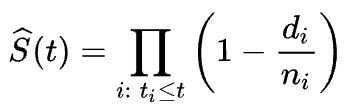

In [15]:
def probabilidade_sobrevivencia(anos_sobrevivencia_serie, T):
  """Calcula a probabilidade de sobrevivência S(t) para um dado tempo T.

  Argumentos:
    years_survived_series: Uma pandas Series contendo os anos sobrevividos por
      cada paciente.
    T: O ponto no tempo para o qual calcular a probabilidade de sobrevivência.

  Retorna:
    Um float representando a probabilidade de sobrevivência S(T).
  """

  prob_sobreviv = 1.0
  for t in range(1, T + 1):

    morreu_antes_ou_em_t = anos_sobrevivencia_serie[(anos_sobrevivencia_serie == t) & (BreastData["Patient_Status"] == 1)].count()
    sobreviveu_pelo_menos_ate_t = anos_sobrevivencia_serie[anos_sobrevivencia_serie >= t].count()
    if sobreviveu_pelo_menos_ate_t == 0:
      continue
    else:
      prob_sobreviv *= (1 - (morreu_antes_ou_em_t / sobreviveu_pelo_menos_ate_t))

  return prob_sobreviv

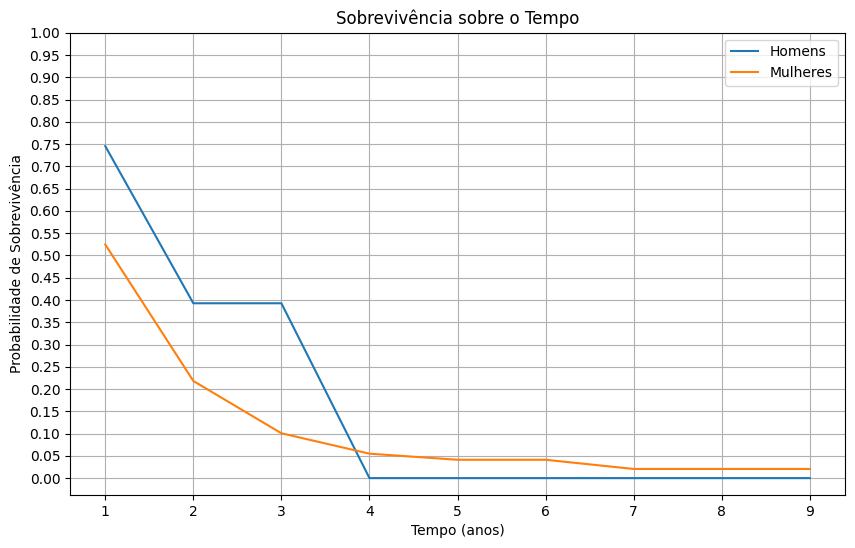

In [16]:
plt.figure(figsize=(10, 6))

survival_probs = []
for T in range(1, 10):
  survival_probs.append(probabilidade_sobrevivencia(BreastData[BreastData["Gender"] == 0]["Years_Survived"], T))
plt.plot(range(1, 10), survival_probs, label="Homens")


survival_probs = []
for T in range(1, 10):
  survival_probs.append(probabilidade_sobrevivencia(BreastData[BreastData["Gender"] == 1]["Years_Survived"], T))
plt.plot(range(1, 10), survival_probs, label="Mulheres")


plt.xlabel("Tempo (anos)")
plt.ylabel("Probabilidade de Sobrevivência")
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title("Sobrevivência sobre o Tempo")
plt.grid(True)
plt.legend()
plt.show()


#### O teste Log-rank pode nos dizer se existe uma diferença estatisticamente significativa entre as curvas de sobrevivência de homens e mulheres com câncer de mama.


In [17]:
def logrank_p_value(group_1_data, group_2_data):
    result = logrank_test(group_1_data.Years_Survived, group_2_data.Years_Survived,
                          group_1_data.Patient_Status, group_2_data.Patient_Status)
    return result.p_value

logrank_p_value(BreastData[BreastData["Gender"] == 0], BreastData[BreastData["Gender"] == 1])

2.6211369503638776e-19


#### O resultado é um valor p extremamente pequeno, menor do que o nível de significância usual de 0.5. Nesse caso isso prova que há uma diferença estatisticamente significante entre as curvas de sobrevivência entre o homem e a mulher.

####  De fato, é observado pela análise das curvas que, à medida que os anos passam, a probabilidade de sobrevivência do homem diminui significativamente se comparado com o mesmo tempo com a mulher. Após 4 anos, há 0% de probabilidade de sobrevivência para o homem. Por outro lado, a probabilidade de sobrevivência do homem em um tempo 1 é significativamente maior que a da mulher.

#### Esses resultados podem ser explicados pelo enorme desbalanceamento de dados entre os gêneros masculinos e femininos (somente 1% dos dados são de pacientes masculinos). Como os dados foram replicados para manter um balanceamento, é justificado a mudança radical de probabilidades de sobrevivência no gênero masculino.



#### Taxa de Perigo ao longo dos Anos


In [18]:
def perigo_tempo_t(anos_sobrevivencia_serie, T):
  """Calcula a taxa de morte no tempo T.

  Argumentos:
    anos_sobrevivencia_serie: Uma pandas Series contendo os anos sobrevividos por
      cada paciente.
    T: O ponto no tempo para o qual calcular o hazard rate.

  Retorna:
    Um float representando o hazard rate em T.
  """
  if T <= 0:
    return 0

  s_t = probabilidade_sobrevivencia(anos_sobrevivencia_serie, T)

  if s_t == 0:
    return 0

  s_t_minus_1 = probabilidade_sobrevivencia(anos_sobrevivencia_serie, T - 1)

  if s_t_minus_1 == 0:
      return 0

  hazard = (s_t_minus_1 - s_t) / s_t

  return hazard

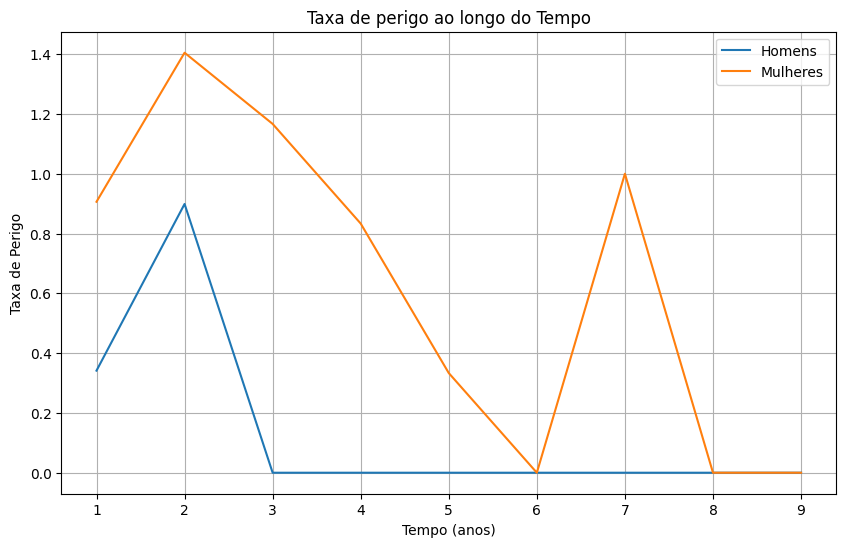

In [19]:
plt.figure(figsize=(10, 6))

hazard_rates = []
for T in range(1, 10):
  hazard_rates.append(perigo_tempo_t(BreastData[BreastData["Gender"] == 0]["Years_Survived"], T))
plt.plot(range(1, 10), hazard_rates, label="Homens")


hazard_rates = []
for T in range(1, 10):
  hazard_rates.append(perigo_tempo_t(BreastData[BreastData["Gender"] == 1]["Years_Survived"], T))
plt.plot(range(1, 10), hazard_rates, label="Mulheres")


plt.xlabel("Tempo (anos)")
plt.ylabel("Taxa de Perigo")
plt.title("Taxa de perigo ao longo do Tempo")
plt.grid(True)
plt.legend()
plt.show()


Dada a seguinte equação onde H(t) representa a taxa de perigo acumulada no tempo T e S(t) a sobrevivência no tempo T. É dado que:

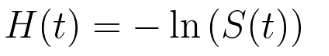

In [34]:
def perigo_acumulado_tempo_t(survival_probability, T):
  """Calcula o risco acumulado H(t) dada a probabilidade de sobrevivência S(t).

  Argumentos:
    probabilidade_sobrevivencia: Um float representando a probabilidade de sobrevivência S(t).

  Retorna:
    Um float representando o risco acumulado H(t).
  """


  prob_sobreviv = probabilidade_sobrevivencia(survival_probability, T)
  if prob_sobreviv == 0:
    return 10 ###Representará infinito

  perigo_acumulado = -np.log(prob_sobreviv)

  return perigo_acumulado


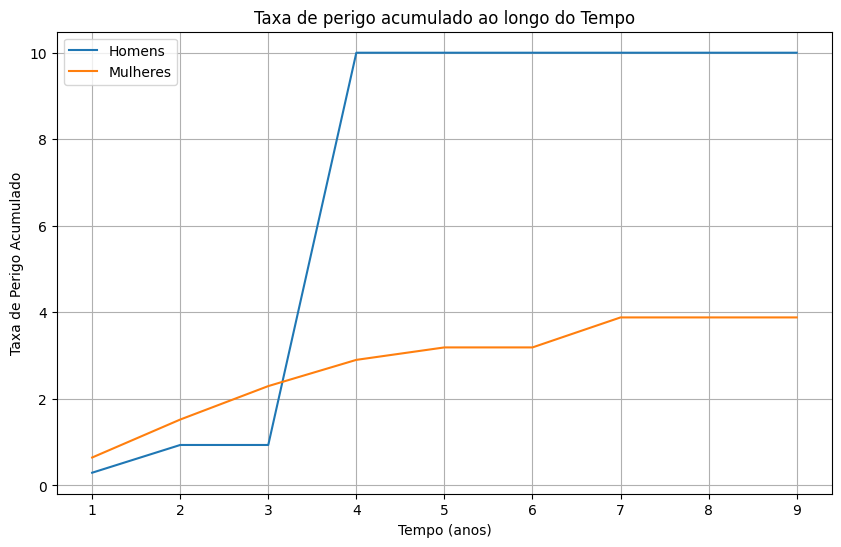

In [37]:
plt.figure(figsize=(10, 6))

hazard_rates = []
for T in range(1, 10):

  hazard_rates.append(perigo_acumulado_tempo_t(BreastData[BreastData["Gender"] == 0]["Years_Survived"], T))
plt.plot(range(1, 10), hazard_rates, label="Homens")


hazard_rates = []
for T in range(1, 10):

  hazard_rates.append(perigo_acumulado_tempo_t(BreastData[BreastData["Gender"] == 1]["Years_Survived"], T))

plt.plot(range(1, 10), hazard_rates, label="Mulheres")


plt.xlabel("Tempo (anos)")
plt.ylabel("Taxa de Perigo Acumulado")
plt.title("Taxa de perigo acumulado ao longo do Tempo")
plt.grid(True)
plt.legend()
plt.show()



#### Como é possível ver tanto homens como as mulheres possuem um risco de morte imediato maior após 2 anos, com um pico, também, em 7 anos para as mulheres.

#### Além disso, pela taxa de perigo acumulado é possível observar que, após 4 anos, a taxa de perigo acumulado atinge praticamente infinito para homens (o que nos diz que, após 4 anos, a morte é praticamente certa para homens), enquanto para mulheres segue crescente até se estabilizar por volta de 7 anos.